In [1]:
# load the required libraries
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import regularizers


import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

import os, time, re
import pandas as pd
import numpy as np
import pickle, gzip

%matplotlib inline

from sklearn.metrics import precision_recall_curve, averageprecision_score
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing as pp
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold 


import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
K = keras.backend
import sys, sklearn



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# set seed to make the output stable
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# credit card data
data = pd.read_csv('/content/credit_card.csv')

In [4]:
# drop the class and time columns in x dataset 
x_data = data.copy().drop(['Class','Time'],axis=1)

# select class column as the class label column 
y_data = data['Class'].copy()

In [5]:
# scale the xdata so that the mean is 0 and std. deviation is 1
scaleFeatures = x_data.columns

scaleX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)

x_data.loc[:,scaleFeatures] = scaleX.fit_transform(x_data[scaleFeatures])

In [6]:
# create the training and test dataset 
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=2018, stratify=y_data)

In [7]:
# view the size of training and test dataset 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(190820, 29)
(93987, 29)
(190820,)
(93987,)


In [8]:
# check the number of labels  having 0 and 1 values 
print(np.sum(y_train==0))

print(np.sum(y_train==1))




190490
330


In [9]:
# drop 80% of the labels from training dataset having value 1 
dropColumns = y_train[y_train==1].sample(frac=0.80,random_state=2018)

X_train.drop(labels=dropColumns.index,inplace=True)

y_train.drop(labels=dropColumns.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
# check the number of labels  having 0 and 1 values after dropping the labels 
print(np.sum(y_train==0))
print(np.sum(y_train==1))



190490
66


In [11]:
# calculate the anamoly score 
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) -  np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [12]:
# function to plot the results 
def plotResults(trueLabels, anomalyScores, returnPreds = False):
  
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    averageprecision = averageprecision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(averageprecision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, averageprecision

In [13]:
# calculate the precision 
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [14]:
# create k-fold stratified to split the dataset 
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)



In [15]:
lightGB_params = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [17]:
trainingScore = []
scorey = []
KFoldPrediction = pd.DataFrame(data=[], index=y_train.index, columns=['prediction'])

for trainindex, cvindex in kfold.split(np.zeros(len(X_train)), y_train.ravel()):

    # get xdata based on the stratified k fold indices 
    xtrainfold, xcvfold = X_train.iloc[trainindex,:], X_train.iloc[cvindex,:]
    # get ydata based on the stratified k fold indices 
    ytrainfold, ycvfold = y_train.iloc[trainindex],   y_train.iloc[cvindex]
    
    # gradient boost the training data using LightGBM
    lgbtrain = lgb.Dataset(xtrainfold, ytrainfold)
    lgbeval = lgb.Dataset(xcvfold, ycvfold, reference=lgbtrain)


    gbm = lgb.train(lightGB_params, lgbtrain, num_boost_round=2000,valid_sets=lgbeval, early_stopping_rounds=200)
    
    # calculate the log loss on the train dataset 
    loglossTraining = log_loss(ytrainfold, gbm.predict(xtrainfold, num_iteration=gbm.best_iteration))
    trainingScore.append(loglossTraining)
    
    # store the predictions 
    KFoldPrediction.loc[xcvfold.index,'prediction'] = gbm.predict(xcvfold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(ycvfold, KFoldPrediction.loc[xcvfold.index,'prediction'])
    scorey.append(loglossCV)
    
    print(f'Training Log Loss: {loglossTraining}')
    print(f'Label Log Loss: {loglossCV}')

[1]	valid_0's binary_logloss: 0.003154
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00275523
[3]	valid_0's binary_logloss: 0.00273438
[4]	valid_0's binary_logloss: 0.00271751
[5]	valid_0's binary_logloss: 0.00270408
[6]	valid_0's binary_logloss: 0.00268104
[7]	valid_0's binary_logloss: 0.00266451
[8]	valid_0's binary_logloss: 0.00265283
[9]	valid_0's binary_logloss: 0.0026419
[10]	valid_0's binary_logloss: 0.00263261
[11]	valid_0's binary_logloss: 0.00262442
[12]	valid_0's binary_logloss: 0.0026162
[13]	valid_0's binary_logloss: 0.00259503
[14]	valid_0's binary_logloss: 0.00257866
[15]	valid_0's binary_logloss: 0.00256063
[16]	valid_0's binary_logloss: 0.0025467
[17]	valid_0's binary_logloss: 0.00253326
[18]	valid_0's binary_logloss: 0.00251888
[19]	valid_0's binary_logloss: 0.00250687
[20]	valid_0's binary_logloss: 0.00249657
[21]	valid_0's binary_logloss: 0.00248578
[22]	valid_0's binary_logloss: 0.00247622
[23]	valid_0's binary_loglo

In [18]:
# calculate the log loss using the LightGBM
lightGBMGradientBoostinglogloss = log_loss(y_train, 
        KFoldPrediction.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(lightGBMGradientBoostinglogloss,4)}')

LightGBM Gradient Boosting Log Loss: 0.0015


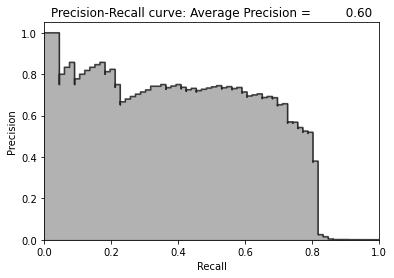

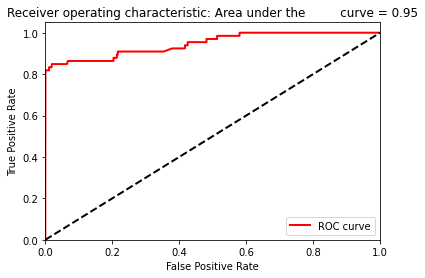

In [19]:
# plot the precision recall curve and ROC curve on training data
preds, averageprecision = plotResults(y_train, KFoldPrediction.loc[:,'prediction'], True)

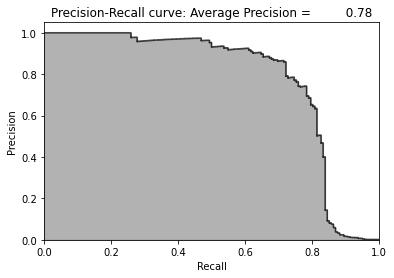

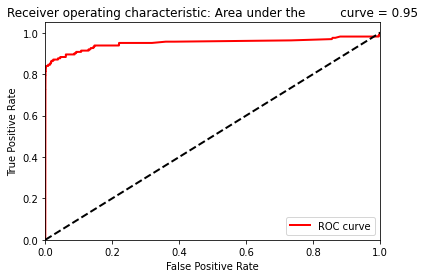

In [21]:
# plot the precision recall curve and ROC curve on test data

predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration), index=X_test.index)
preds, averageprecision = plotResults(y_test, predictions, True)

In [23]:
# calculate the precision and recall

preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'recall {round(precision,4)}')

recall 0.764


In [24]:
# duplicate the fraudulent cases 100 times. append them to the training set

oversamplemultiplier = 100

Xtrain_orig = X_train.copy()
ytrain_orig = y_train.copy()
Xtest_orig = X_test.copy()
ytest_orig = y_test.copy()

# oversample the data 
Xtrain_oversamp = X_train.copy()
ytrain_oversamp = y_train.copy()
Xtrain_oversamp = Xtrain_oversamp.append(  [Xtrain_oversamp[y_train==1]]*oversamplemultiplier,  ignore_index=False)
ytrain_oversamp = ytrain_oversamp.append( [ytrain_oversamp[y_train==1]]*oversamplemultiplier,  ignore_index=False)

X_train = Xtrain_oversamp.copy()
y_train = ytrain_oversamp.copy()

In [25]:
X_train.shape, y_train.shape


((197156, 29), (197156,))

In [26]:
# define the NN model 
model = Sequential()
model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(1e-4),input_dim=29, name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [28]:
# compile the model woth MSE loss and adam optimiser  
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [29]:
# fir the model o the training dataset 
num_epochs =  5
batch_size = 32

history = model.fit(x=X_train, y=X_train, epochs=num_epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.20, verbose=1)

Epoch 1/5
4929/4929 [==============================] - 7s 1ms/step - loss: 0.0792 - accuracy: 0.8616 - val_loss: 0.0458 - val_accuracy: 0.9808
Epoch 2/5
4929/4929 [==============================] - 6s 1ms/step - loss: 0.0181 - accuracy: 0.9255 - val_loss: 0.0180 - val_accuracy: 0.9837
Epoch 3/5
4929/4929 [==============================] - 6s 1ms/step - loss: 0.0174 - accuracy: 0.9265 - val_loss: 0.0126 - val_accuracy: 0.9875
Epoch 4/5
4929/4929 [==============================] - 6s 1ms/step - loss: 0.0176 - accuracy: 0.9257 - val_loss: 0.0140 - val_accuracy: 0.9746
Epoch 5/5
4929/4929 [==============================] - 6s 1ms/step - loss: 0.0173 - accuracy: 0.9263 - val_loss: 0.0143 - val_accuracy: 0.9808


5955/5955 [==============================] - 4s 657us/step


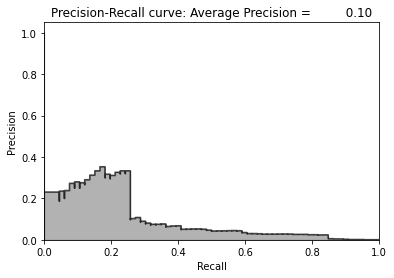

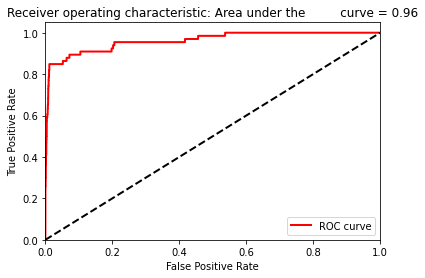

In [32]:
# plot the precision recall and ROC curve 
predictionsTrain = model.predict(Xtrain_orig, verbose=1)
anomalyScoresAETrain = anomalyScores(Xtrain_orig, predictionsTrain)
preds, averageprecision = plotResults(ytrain_orig, anomalyScoresAETrain, True)

2938/2938 [==============================] - 2s 663us/step


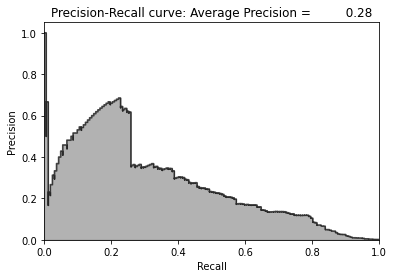

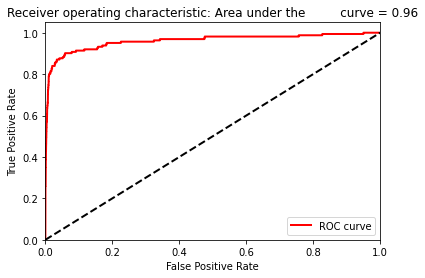

In [33]:
# plot the precision recall and ROC curve 

predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, averageprecision = plotResults(y_test, anomalyScoresAE, True)

In [35]:
# calculate the precision 
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f' recall {round(precision,4)}')

 recall 0.1186


In [36]:
# define a hidden layer and use it predict the y values for train and test data
layername = 'hidden_layer'

intermediatelayer  = Model(inputs=model.input, outputs=model.get_layer(layername).output)
intermediateoptrain = intermediatelayer.predict(Xtrain_orig)
intermediateoptest  = intermediatelayer.predict(Xtest_orig)

In [37]:
intermediateoptrainDF = pd.DataFrame(data=intermediateoptrain,index=Xtrain_orig.index)
intermediateoptestDF  = pd.DataFrame(data=intermediateoptest,index=Xtest_orig.index)

In [38]:
X_train = Xtrain_orig.merge(intermediateoptrainDF, left_index=True,right_index=True)
X_test  = Xtest_orig.merge(intermediateoptestDF, left_index=True,right_index=True)
y_train = ytrain_orig.copy()

In [39]:
# using k fold stratification, divide the dataset. 
# using above logic, again calculate training and y label loss 
trainingScore = []
scorey = []
KFoldPrediction = pd.DataFrame(data=[],index=y_train.index,  columns=['prediction'])

for trainindex, cvindex in kfold.split(np.zeros(len(X_train)), y_train.ravel()):

    # get x values from the stratified dataset 
    xtrainfold, xcvfold = X_train.iloc[trainindex,:], X_train.iloc[cvindex,:]

    # get y values from the stratified dataset 
    ytrainfold, ycvfold = y_train.iloc[trainindex], y_train.iloc[cvindex]
    
    # using LightGBM, get training and evaluation dataset 
    lgbtrain = lgb.Dataset(xtrainfold, ytrainfold)
    lgbeval = lgb.Dataset(xcvfold, ycvfold, reference=lgbtrain)
    gbm = lgb.train(lightGB_params, lgbtrain, num_boost_round=5000,valid_sets=lgbeval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(ytrainfold, gbm.predict(xtrainfold,num_iteration=gbm.best_iteration))
    trainingScore.append(loglossTraining)
    
    KFoldPrediction.loc[xcvfold.index,'prediction'] = gbm.predict(xcvfold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(ycvfold, KFoldPrediction.loc[xcvfold.index,'prediction'])
    scorey.append(loglossCV)
    
    print(f'Log Loss - Training: {round(loglossTraining,4)}')
    print(f'Log Loss - CV: {round(loglossCV,4)}' )

[1]	valid_0's binary_logloss: 0.00129798
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00129526
[3]	valid_0's binary_logloss: 0.00133134
[4]	valid_0's binary_logloss: 0.00132666
[5]	valid_0's binary_logloss: 0.00132265
[6]	valid_0's binary_logloss: 0.00131583
[7]	valid_0's binary_logloss: 0.00131271
[8]	valid_0's binary_logloss: 0.00130927
[9]	valid_0's binary_logloss: 0.001305
[10]	valid_0's binary_logloss: 0.00130196
[11]	valid_0's binary_logloss: 0.00131238
[12]	valid_0's binary_logloss: 0.00132983
[13]	valid_0's binary_logloss: 0.00136175
[14]	valid_0's binary_logloss: 0.00143666
[15]	valid_0's binary_logloss: 0.00171442
[16]	valid_0's binary_logloss: 0.002482
[17]	valid_0's binary_logloss: 0.0024744
[18]	valid_0's binary_logloss: 0.00246699
[19]	valid_0's binary_logloss: 0.00246029
[20]	valid_0's binary_logloss: 0.00245392
[21]	valid_0's binary_logloss: 0.0024504
[22]	valid_0's binary_logloss: 0.00244484
[23]	valid_0's binary_loglos

In [40]:
# gradient boost the training data using LightGBM
lightGBMGradientBoostinglogloss = log_loss(y_train, KFoldPrediction.loc[:,'prediction'])
print(f'LightGBM Log Loss: {round(lightGBMGradientBoostinglogloss,4)}')

LightGBM Log Loss: 0.0018


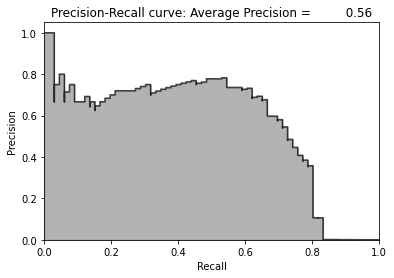

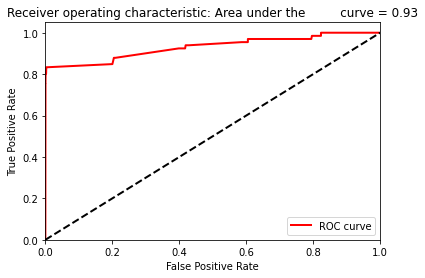

In [41]:
# plot the precision recall and ROC curve for train data

preds, averageprecision = plotResults(y_train, KFoldPrediction.loc[:,'prediction'], True)


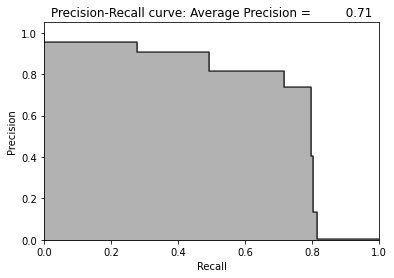

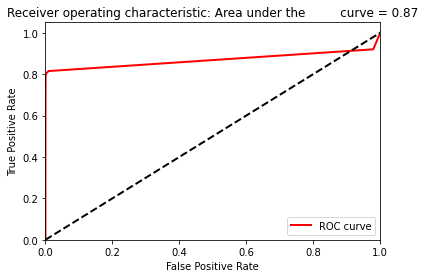

In [42]:
# plot the precision recall and ROC curve for test data

predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)
preds, averageprecision = plotResults(y_test, predictions, True)

In [43]:
# calculate the precision 
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'{round(precision,4)}')

0.7885


In [44]:
# calculate the importance of features in the dataset 
featuresImp = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])
featuresImp = featuresImp/featuresImp.sum()
featuresImp.sort_values(by='featImportance', ascending=False,inplace=True)
featuresImp

,featImportance
34,0.153846
V1,0.076923
38,0.076923
12,0.076923
V7,0.076923
...,...
2,0.000000
4,0.000000
V2,0.000000
6,0.000000
